# Time Series Prediction

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten
import json

In [48]:
# Read in feature data
with open('feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None 
for i in database:
    new_data = pd.read_json(database[i]['data'])
    if new_data.shape[0] > 32:  # Filter CO2 data
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print("Feature not used:")
        print(i)
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(feature_data.shape)

Feature not used:
E_Mio.tonnes_CO2
Feature not used:
M_Mio.tonnes_CO2
Feature not used:
ECO_Mio.tonnes_CO2
(110, 40)


In [49]:
# Read in emission data
emission_data = pd.read_csv(
    "oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv")
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(emission_data.shape)

(110,)


In [50]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	return np.array(dataX), np.array(dataY)

In [51]:
scaler = StandardScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

# Create datasets
# trainX, trainY = sliding_window(feature_data[0:train_size,:],
#                                 emission_data[0:train_size],
#                                 look_back,
#                                 horizon)
# testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
#                               emission_data[train_size:len(emission_data)],
#                               look_back,
#                               horizon)
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(70, 12)
(70, 6)
(4, 12)
(4, 6)


## Multilayer Perceptron Regression

In [52]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    model = Sequential()
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(trainX.shape[2]*look_back,
                        input_dim=trainX.shape[2]*look_back,
                        activation='relu'))
        model.add(Dense(int(trainX.shape[2]/4)*look_back,
                        input_dim=(trainX.shape[2]*look_back),
                        activation='relu'))
        model.add(Dense(int(trainX.shape[2]/8)*look_back,
                        input_dim=(trainX.shape[2]*look_back)/4,
                        activation='relu'))
    else:
        model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [53]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/400
 - 0s - loss: 5436.2482
Epoch 2/400
 - 0s - loss: 1083.4737
Epoch 3/400
 - 0s - loss: 152.7079
Epoch 4/400
 - 0s - loss: 58.8217
Epoch 5/400
 - 0s - loss: 42.6963
Epoch 6/400
 - 0s - loss: 40.2777
Epoch 7/400
 - 0s - loss: 39.2823
Epoch 8/400
 - 0s - loss: 37.3585
Epoch 9/400
 - 0s - loss: 35.3499
Epoch 10/400
 - 0s - loss: 34.2654
Epoch 11/400
 - 0s - loss: 32.7770
Epoch 12/400
 - 0s - loss: 32.0280
Epoch 13/400
 - 0s - loss: 31.1260
Epoch 14/400
 - 0s - loss: 29.4200
Epoch 15/400
 - 0s - loss: 29.8366
Epoch 16/400
 - 0s - loss: 27.7393
Epoch 17/400
 - 0s - loss: 27.5299
Epoch 18/400
 - 0s - loss: 26.3384
Epoch 19/400
 - 0s - loss: 25.7500
Epoch 20/400
 - 0s - loss: 25.3215
Epoch 21/400
 - 0s - loss: 24.3218
Epoch 22/400
 - 0s - loss: 23.1345
Epoch 23/400
 - 0s - loss: 23.8532
Epoch 24/400
 - 0s - loss: 22.9679
Epoch 25/400
 - 0s - loss: 22.3348
Epoch 26/400
 - 0s - loss: 21.4996
Epoch 27/400
 - 0s - loss: 21.9298
Epoch 28/400
 - 0s - loss: 20.8889
Epoch 29/400
 - 0s - los

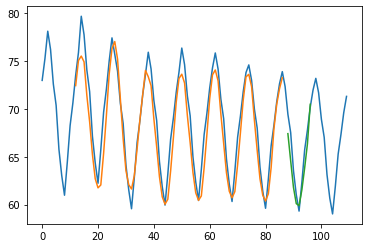

In [54]:
# Plot baseline and predictions
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.show()

In [55]:
import pickle

# Save variables
with open('mlp.pkl', 'wb') as f:
    pickle.dump([model, trainPredictPlot, testPredictPlot], f)

# Getting back the objects:
# with open('mlp.pkl', 'rb') as f:
#     model, trainPlot, testPlot = pickle.load(f)

In [57]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
# X = np.zeros((1, look_back, feature_data.shape[1]))
# X[0] = feature_data[len(feature_data)-look_back:, :]
# predict = model.predict(X)
# forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

# Emissions
X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

In [68]:
print(f"Forecast: {predict}")

Forecast: [[71.15723  70.141785 67.95139  64.76387  61.458412 60.76384 ]]


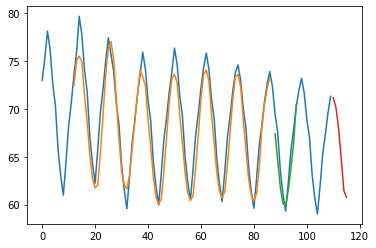

In [59]:
# Plot baseline and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()